In [1]:
import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

from pyarrow import parquet

from gPhoton.parquet_utils import parquet_to_ndarray

from astropy.table import Table

from gPhoton.aspect import load_aspect_solution

from gPhoton.io.raw6 import load_raw6

from gPhoton.io._query.mast_query import retrieve_aspect
from gPhoton.io.mast import get_raw_paths 

In [2]:
def look_at_hdul(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/glcat/astrometry', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    
    return hdul 

In [ ]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [ ]:
def get_image_file(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/gphoton_working/test_data', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]
    
    masked_cnt_image = zero_flag_and_edge(cnt, flag, edge)
    return masked_cnt_image

In [3]:
# boresight parquet 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/boresight.parquet')
bore = parq.to_pandas()

In [2]:
# loading aspect table 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/aspect.parquet')
aspect = parq.to_pandas()
#aspect["eclipse"==9869]

In [5]:
aspect

,eclipse,time,ra,dec,roll,flags
0,580,7.389973e+08,210.540477,-32.673776,0.001104,49
1,580,7.389973e+08,210.540048,-32.673958,0.001257,49
2,580,7.389973e+08,210.539618,-32.674159,0.001586,49
3,580,7.389973e+08,210.539168,-32.674489,0.002005,49
4,580,7.389973e+08,210.538610,-32.674799,0.002408,49
...,...,...,...,...,...,...
43094675,46834,1.012655e+09,180.598848,-19.820267,37.036690,64
43094676,46834,1.012655e+09,180.598884,-19.820535,37.036325,64
43094677,46834,1.012655e+09,180.599141,-19.820719,37.035851,64
43094678,46834,1.012655e+09,180.599371,-19.820848,37.035380,64


In [8]:
# loading aspect table 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/aspect2.parquet')
aspect2 = parq.to_pandas()
#aspect["eclipse"==9869]

In [9]:
aspect2

,eclipse,time,ra,dec,roll,flags
0,580,7.389973e+08,210.540477,-32.673776,0.001104,49
1,580,7.389973e+08,210.540048,-32.673958,0.001257,49
2,580,7.389973e+08,210.539618,-32.674159,0.001586,49
3,580,7.389973e+08,210.539168,-32.674489,0.002005,49
4,580,7.389973e+08,210.538610,-32.674799,0.002408,49
...,...,...,...,...,...,...
43094675,46834,1.012655e+09,180.598848,-19.820267,37.036690,64
43094676,46834,1.012655e+09,180.598884,-19.820535,37.036325,64
43094677,46834,1.012655e+09,180.599141,-19.820719,37.035851,64
43094678,46834,1.012655e+09,180.599371,-19.820848,37.035380,64


In [116]:
get_raw_paths(41211)

{'NUV': 'http://galex.stsci.edu/gPhoton/RAW6.2/e41200_41299/41211/e41211-nd-raw6.fits.gz',
 'FUV': None,
 'scst': 'http://galex.stsci.edu/gPhoton/RAW6.2/e41200_41299/41211/e41211-scst.fits.gz'}

In [4]:
st_71[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT = '        '           /   FITS (Flexible Image Transport System) format
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
GRELEASE= 'ops-v7_2_1'                                                          
TRANGE0 = '050304T145303Z'                                                      
TRANGE1 = '050304T163139Z'                                                      
RA_CENT =           161.753876                                                  
DEC_CENT=            57.899605                                                  
MPSTYPE = 'DIS     '                                                            
MPSPLAN = 'deep    '        

In [70]:
st_69[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT = '        '           /   FITS (Flexible Image Transport System) format
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
GRELEASE= 'ops-v7_2_1'                                                          
TRANGE0 = '050304T113547Z'                                                      
TRANGE1 = '050304T131424Z'                                                      
RA_CENT =           160.698944                                                  
DEC_CENT=             58.51759                                                  
MPSTYPE = 'DIS     '                                                            
MPSPLAN = 'deep    '        

In [ ]:
111019T011259Z                                                    
11-10-19 T 01:12:59 Zulu time 

111019T012235Z
11-10-19 T 01:22:35 Zulu time (ct)
        
111115T115029Z
11-11-15 T 11:50:29 Z
        
111001T155122Z
11-10-01 T 15:51:22 Z 

<IPython.core.display.Javascript object>


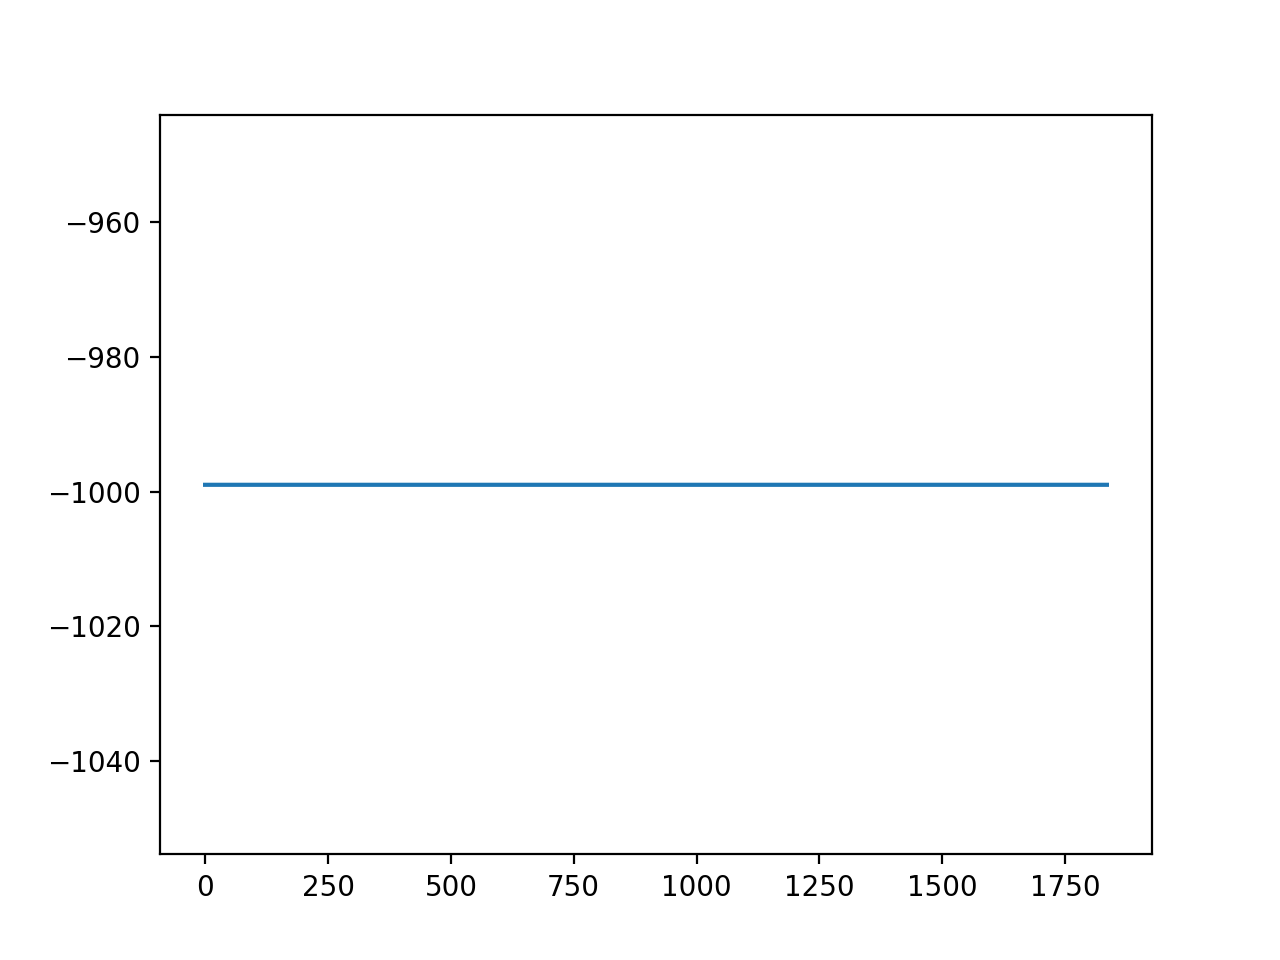

In [40]:
plt.plot(st_69[1].data['status_flag_rta'])

In [35]:
st_71[1].data['comment ']

chararray(['', '', '', ..., '', '', ''], dtype='<U80')

<IPython.core.display.Javascript object>


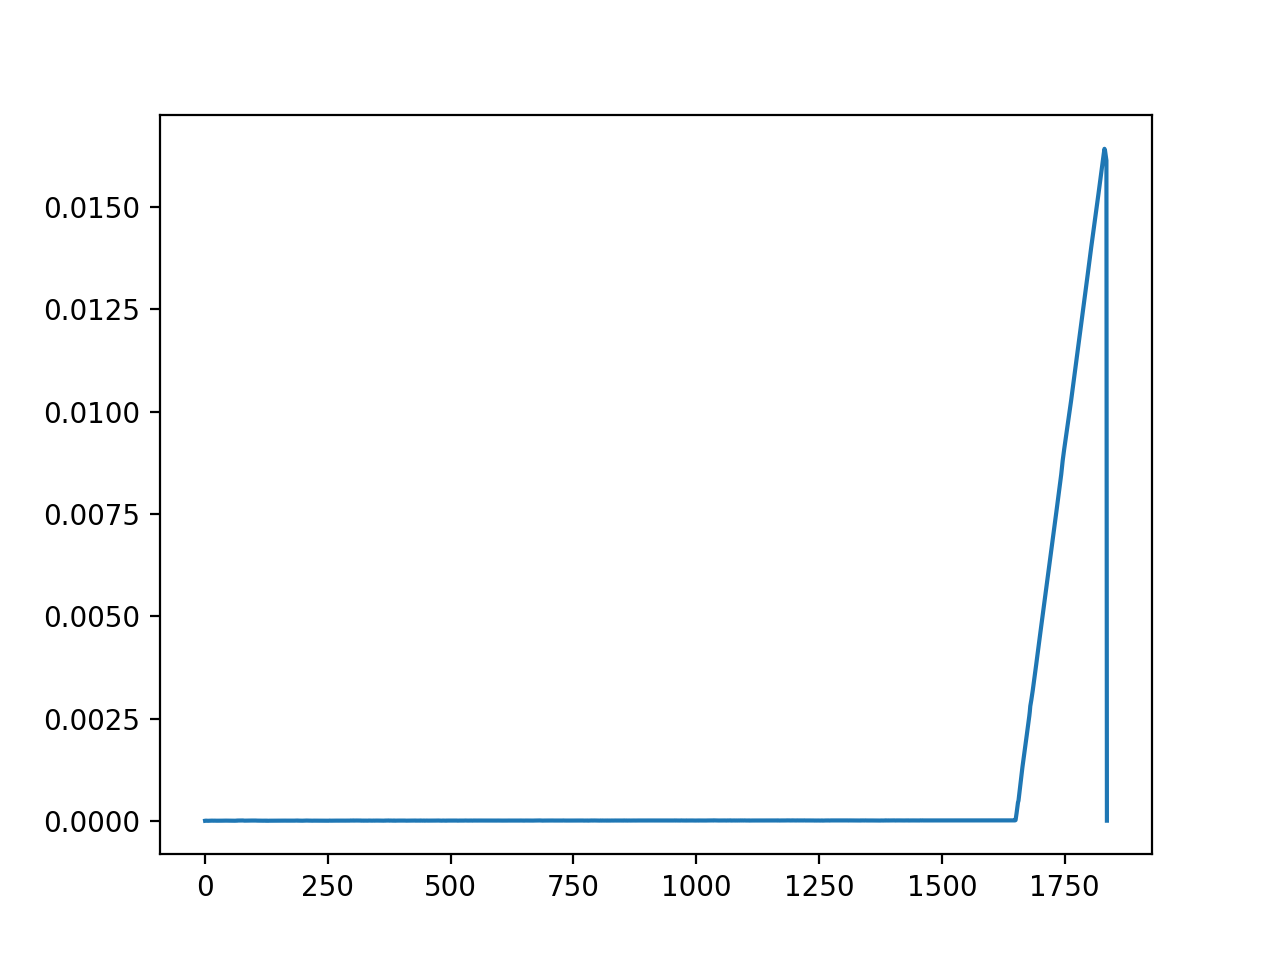

In [29]:
plt.plot(st_71[1].data["gyro_rate_rss"])

In [69]:
st_30738[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT = '        '           /   FITS (Flexible Image Transport System) format
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
GRELEASE= 'ops-v7_2_1'                                                          
TRANGE0 = '080716T065855Z'                                                      
TRANGE1 = '080716T073601Z'                                                      
RA_CENT =                328.4                                                  
DEC_CENT=                17.54                                                  
MPSTYPE = 'NGS     '                                                            
MPSPLAN = 'ngs     '        

In [117]:
st_41211 = fits.open("/home/bekah/gphoton_working/test_data/e41211-scst.fits")

In [130]:
st_41211[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT = '        '           /   FITS (Flexible Image Transport System) format
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
GRELEASE= 'ops-v7_2_1'                                                          
TRANGE0 = '110118T140731Z'                                                      
TRANGE1 = '110118T154604Z'                                                      
RA_CENT =             136.8715                                                  
DEC_CENT=              21.8421                                                  
MPSTYPE = 'MIS     '                                                            
MPSPLAN = 'mis     '        

<IPython.core.display.Javascript object>


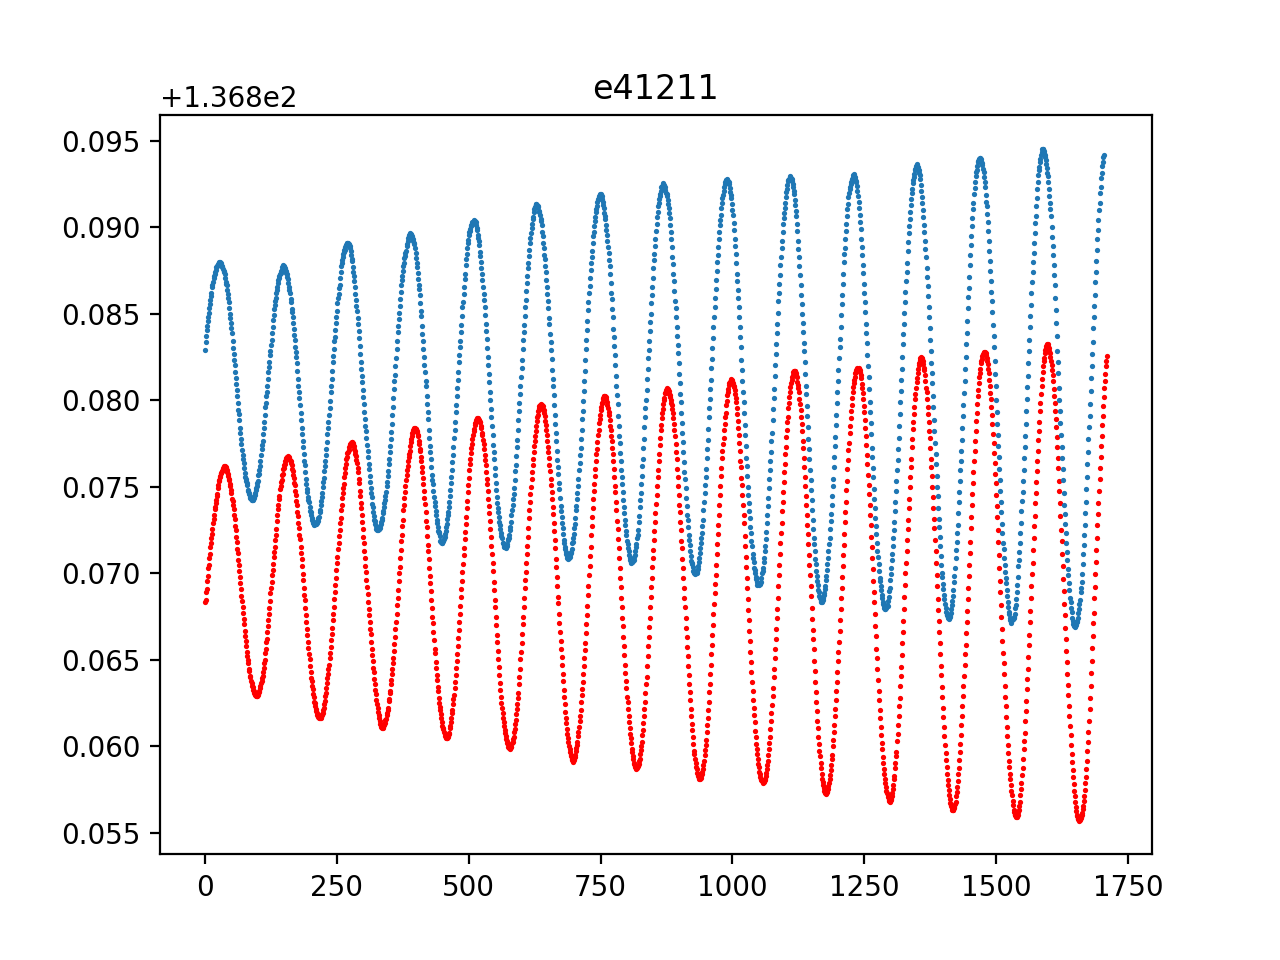

Text(0.5, 1.0, 'e41211')

In [129]:
%matplotlib notebook

rollacs_71 = pd.DataFrame(st_41211[1].data['ra_acs'])
rollacs_71 = rollacs_71.truncate(after=1710)
plt.scatter(rollacs_71.index,rollacs_71[0],s=0.8,c="red")
#plt.plot(st_69[1].data['roll_acs'])
asprta_roll_9871 = aspect[aspect["eclipse"]==41211]["ra"].reset_index()
plt.scatter(asprta_roll_9871.index,asprta_roll_9871["ra"],s=0.8)
#plt.xlim([0, 1600])
plt.title("e41211")

<IPython.core.display.Javascript object>


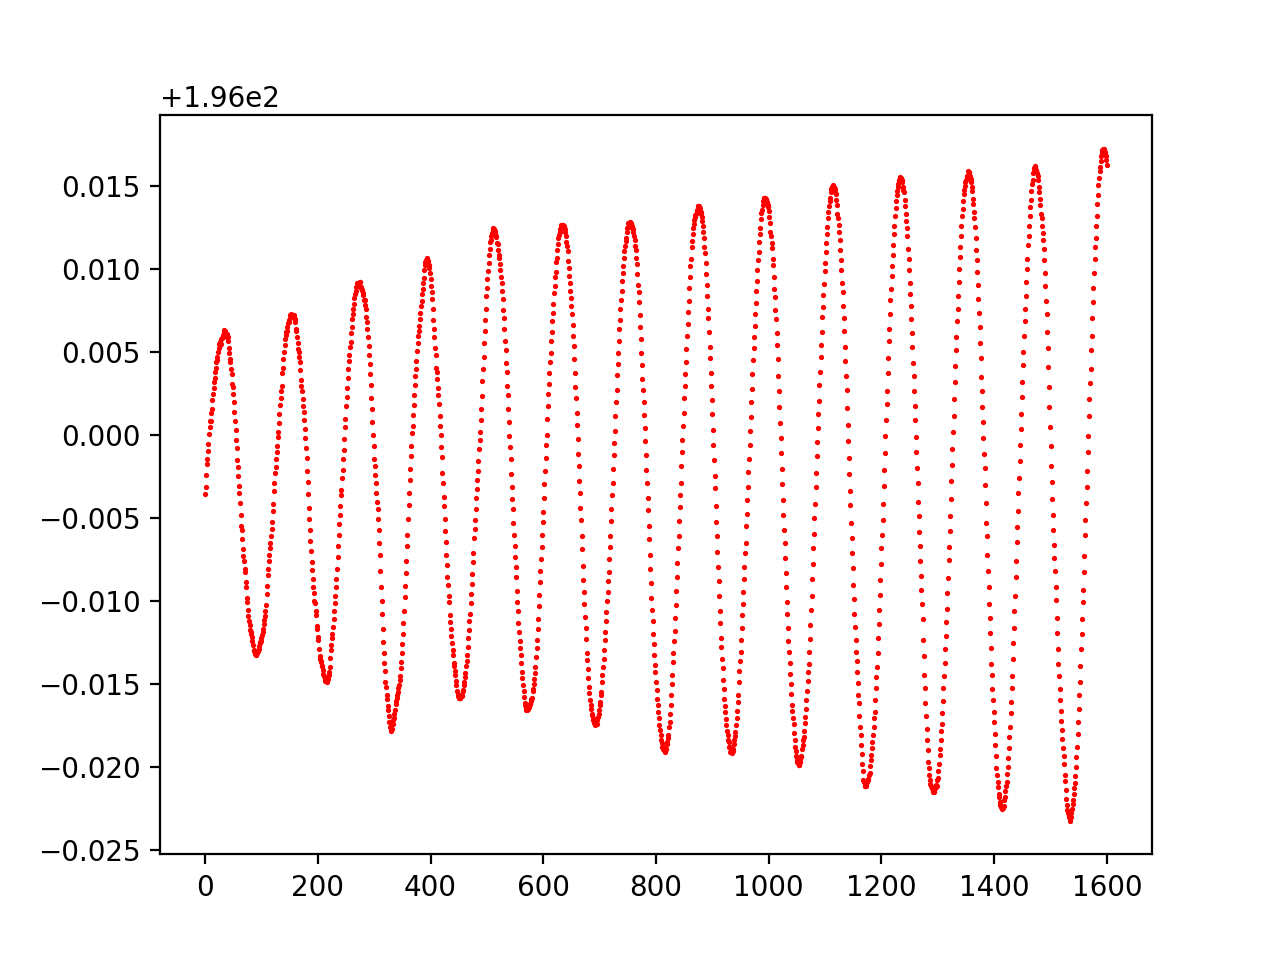

NameError: name 'aspect' is not defined

In [2]:
%matplotlib notebook
st_71 = fits.open("/home/bekah/gphoton_working/test_data/e09871/e09871-scst.fits")
rollacs_71 = pd.DataFrame(st_71[1].data['roll_acs'])
rollacs_71 = rollacs_71.truncate(after=1600)
plt.scatter(rollacs_71.index,rollacs_71[0],s=0.8,c="red")
#plt.plot(st_69[1].data['roll_acs'])
asprta_roll_9871 = aspect[aspect["eclipse"]==9871]["roll"].reset_index()
plt.scatter(asprta_roll_9871.index,asprta_roll_9871["roll"],s=0.8)
#plt.xlim([0, 1600])
plt.title("e9871")

<IPython.core.display.Javascript object>


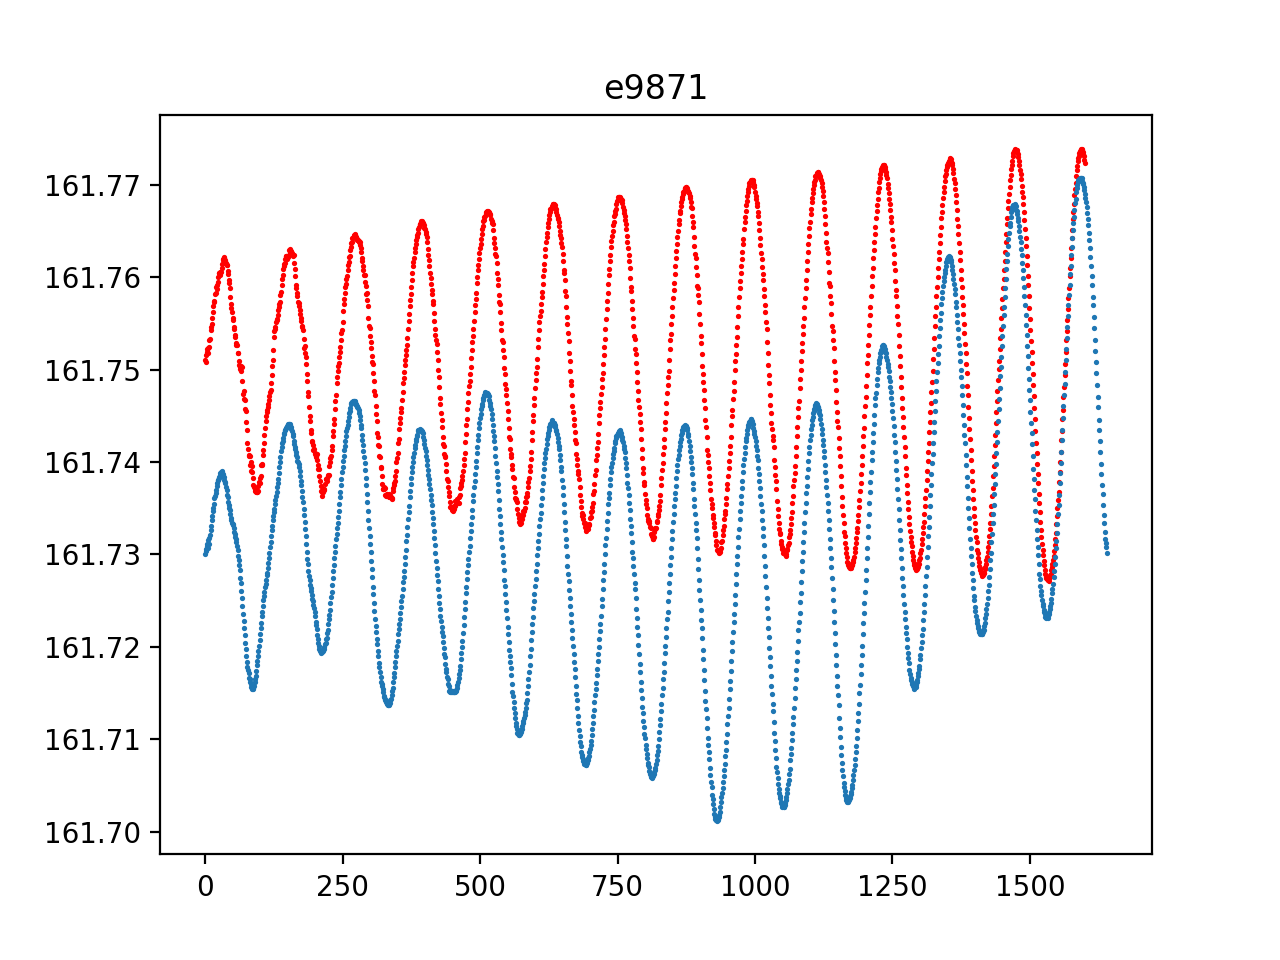

Text(0.5, 1.0, 'e9871')

In [7]:
rollacs_71 = pd.DataFrame(st_71[1].data['ra_acs'])
rollacs_71 = rollacs_71.truncate(after=1600)
plt.scatter(rollacs_71.index,rollacs_71[0],s=0.8,c="red")
#plt.plot(st_69[1].data['roll_acs'])
asprta_roll_9871 = aspect[aspect["eclipse"]==9871]["ra"].reset_index()
plt.scatter(asprta_roll_9871.index,asprta_roll_9871["ra"],s=0.8)
#plt.xlim([0, 1600])
plt.title("e9871")

<IPython.core.display.Javascript object>


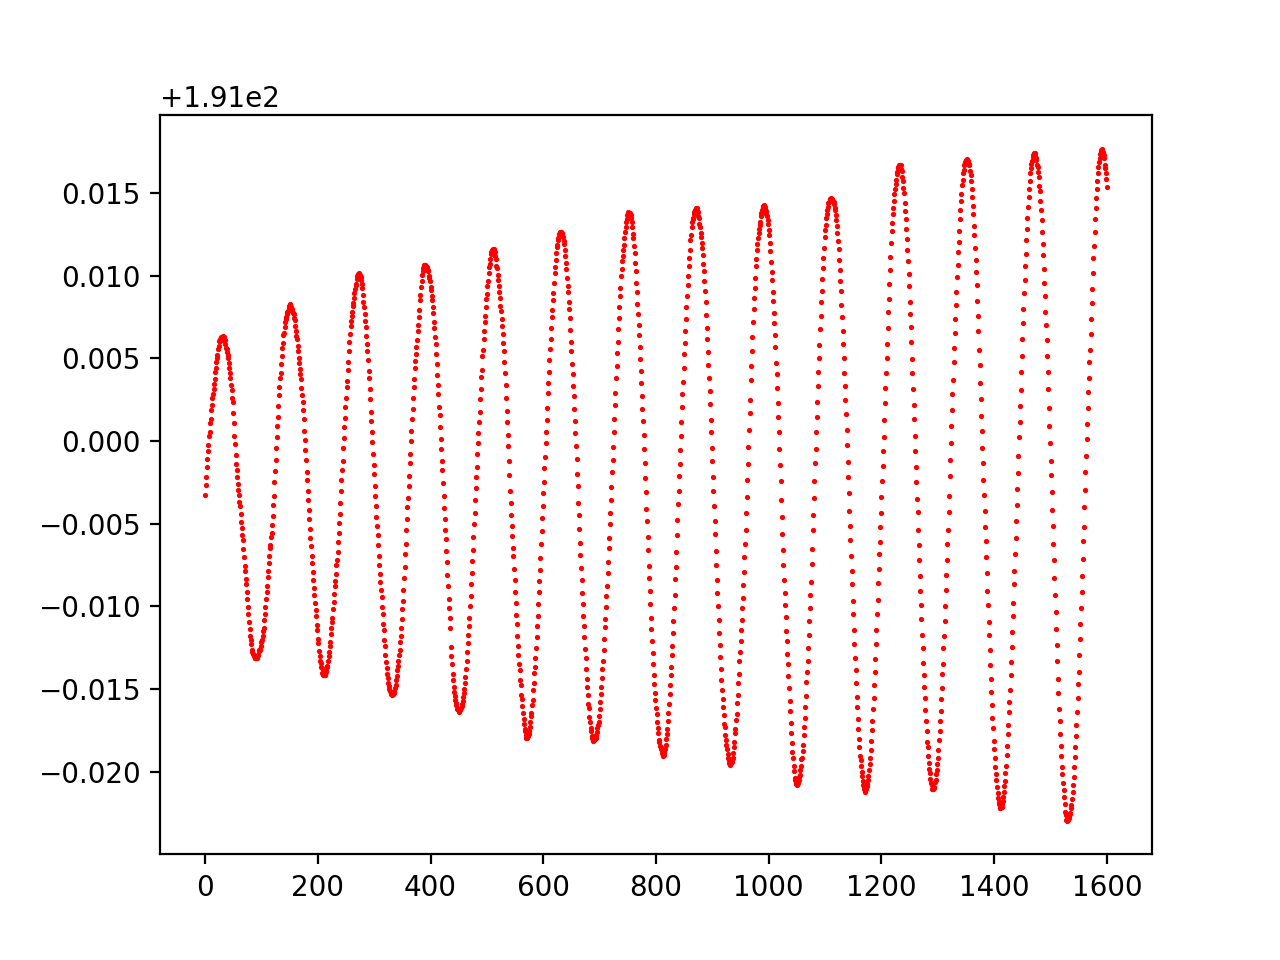

NameError: name 'aspect' is not defined

In [5]:
st_69 = fits.open("/home/bekah/gphoton_working/test_data/e09869/e09869-scst.fits")
rollacs_69 = pd.DataFrame(st_69[1].data['roll_acs'])
rollacs_69 = rollacs_69.truncate(after=1600)
plt.scatter(rollacs_69.index,rollacs_69[0],s=0.8,c="red")
#plt.plot(st_69[1].data['roll_acs'])
asprta_roll_9869 = aspect[aspect["eclipse"]==9869]["roll"].reset_index()
plt.scatter(asprta_roll_9869.index,asprta_roll_9869["roll"],s=0.8)
#plt.xlim([0, 1600])
plt.title("e9869")

<IPython.core.display.Javascript object>


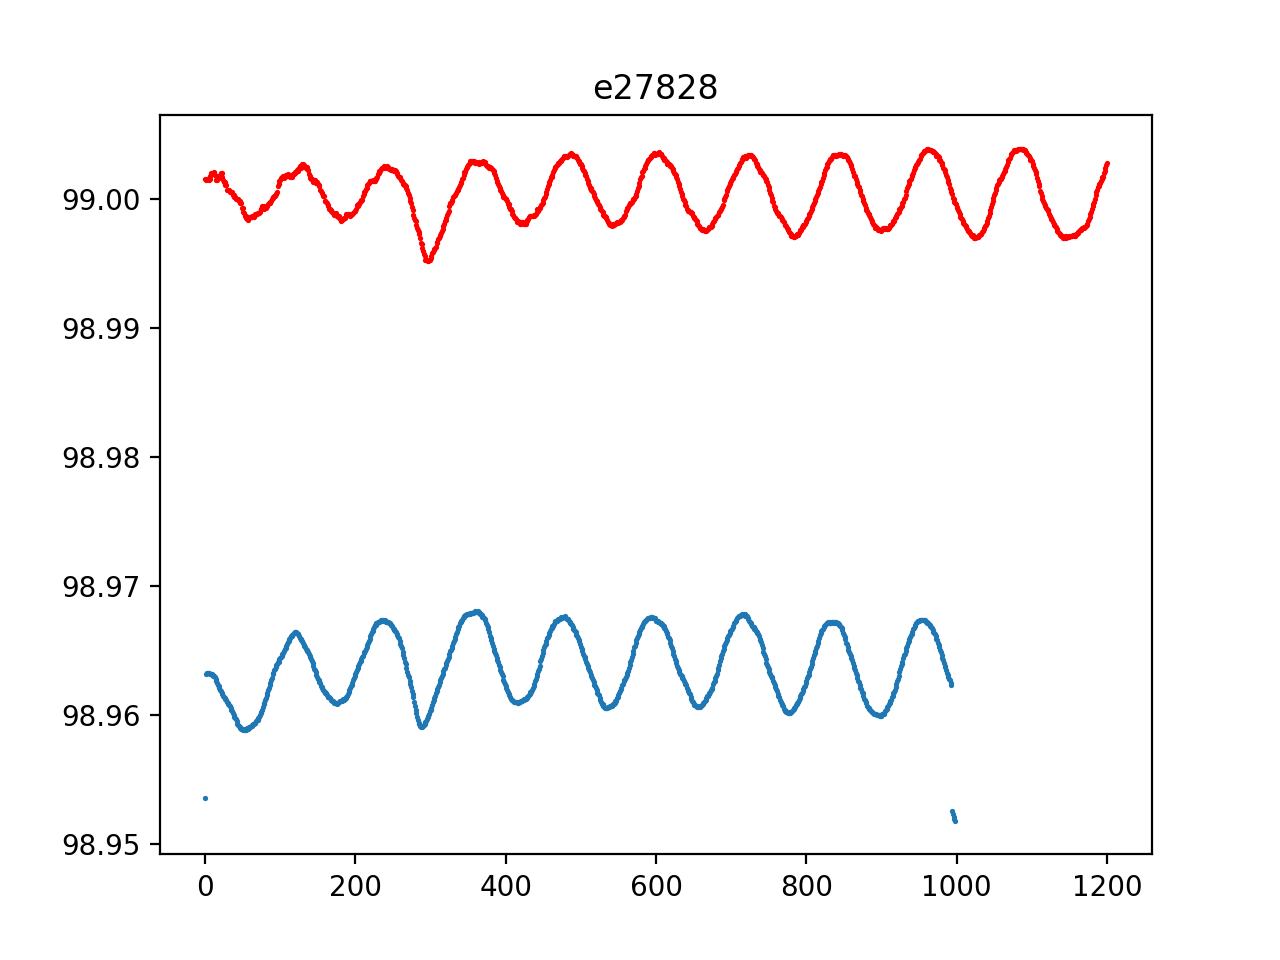

Text(0.5, 1.0, 'e27828')

In [51]:
st_30738 = fits.open("/home/bekah/gphoton_working/test_data/e27828-scst.fits")
rollacs_30738 = pd.DataFrame(st_30738[1].data['roll_acs'])
rollacs_30738 = rollacs_30738.truncate(after=1200)
plt.scatter(rollacs_30738.index,rollacs_30738[0],s=0.8,c="red")
#plt.plot(st_69[1].data['roll_acs'])
asprta_roll_30738 = aspect[aspect["eclipse"]==27828]["roll"].reset_index()
plt.scatter(asprta_roll_30738.index,asprta_roll_30738["roll"],s=0.8)
#plt.xlim([0, 1600])
plt.title("e27828")

<IPython.core.display.Javascript object>


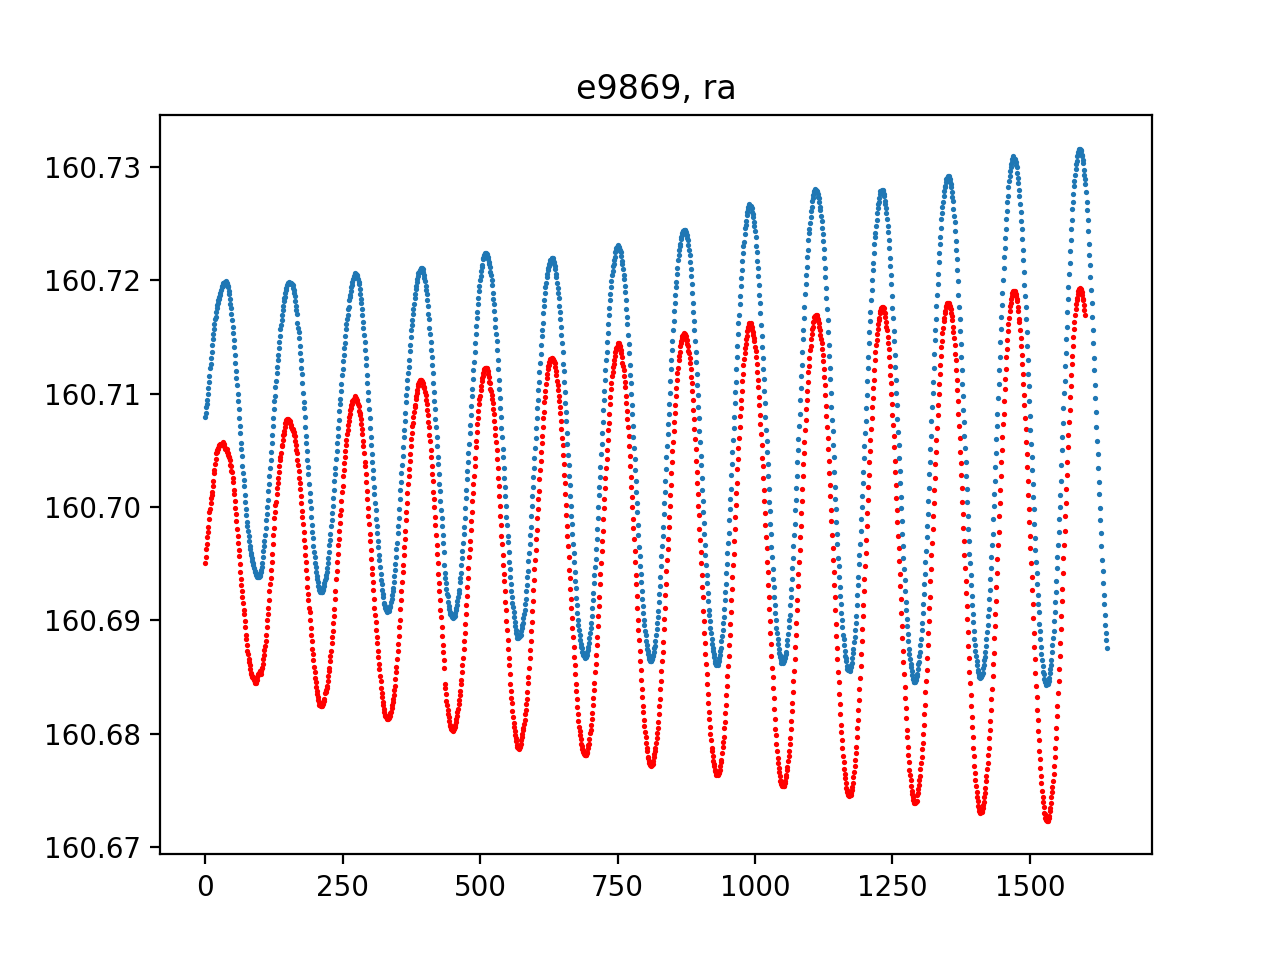

Text(0.5, 1.0, 'e9869, ra')

In [9]:
rollacs_69 = pd.DataFrame(st_69[1].data['ra_acs'])
rollacs_69 = rollacs_69.truncate(after=1600)
plt.scatter(rollacs_69.index,rollacs_69[0],s=0.8,c="red")
#plt.plot(st_69[1].data['roll_acs'])
asprta_roll_9869 = aspect[aspect["eclipse"]==9869]["ra"].reset_index()
plt.scatter(asprta_roll_9869.index,asprta_roll_9869["ra"],s=0.8)
#plt.xlim([0, 1600])
plt.title("e9869, ra")

<IPython.core.display.Javascript object>


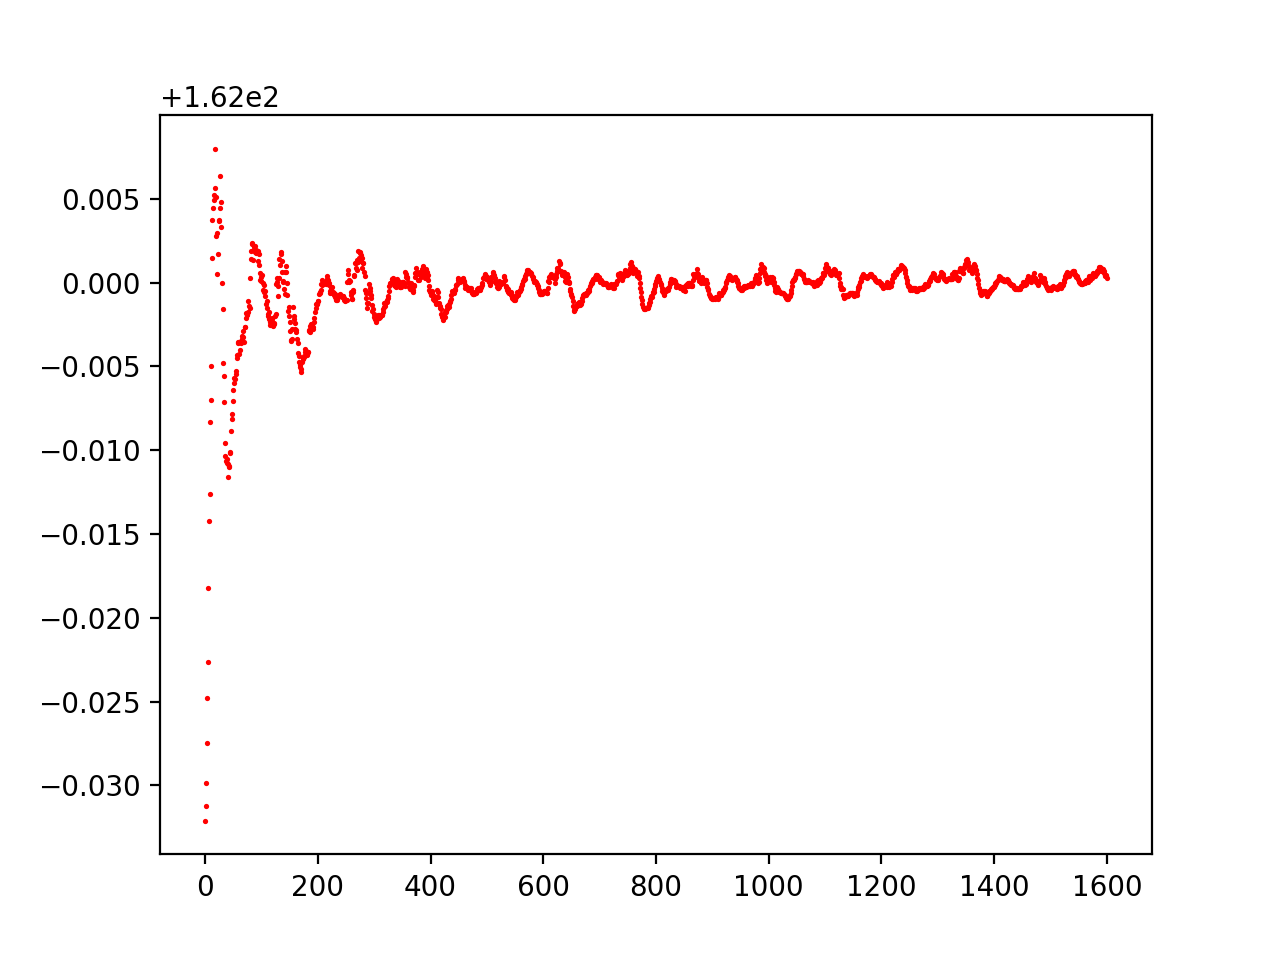

NameError: name 'aspect' is not defined

In [9]:
%matplotlib notebook
st_26076 = fits.open("/home/bekah/gphoton_working/test_data/e26076-scst.fits")
rollacs_26076 = pd.DataFrame(st_26076[1].data['roll_acs'])
rollacs_26076 = rollacs_26076.truncate(after=1600)
plt.scatter(rollacs_26076.index,rollacs_26076[0],s=0.8,c="red")
#plt.plot(st_69[1].data['roll_acs'])
asprta_roll_26076 = aspect[aspect["eclipse"]==26076]["roll"].reset_index()
plt.scatter(asprta_roll_26076.index,asprta_roll_26076["roll"],s=0.8)
#plt.xlim([0, 1600])
plt.title("e26076")

In [ ]:
# 9871
d9871_asp_soln = pd.read_csv("/home/bekah/glcat_tests/aspect_solns/e09871_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho")
asprta_roll_9871 = aspect[aspect["eclipse"]==9871]["roll"].reset_index()
diff_9871 = abs((asprta_roll_9871["roll"])-(d9871_asp_soln['orientation']+360))
value_1 = abs(diff_9871.values)/abs(asprta_roll_9871["roll"])
# plotting 
#plt.plot(diff_9871.index, diff_9871.values)
plt.plot(value_1.index,value_1.values)
plt.title("E9871")plt.ylabel("Diff in Roll, (mission roll - astrometry.net roll) ")
plt.xlabel("Frame")


In [ ]:
#value_1 9871 
d9871_asp_soln = pd.read_csv("/home/bekah/glcat_tests/aspect_solns/e09871_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho")
asprta_roll_9871 = aspect[aspect["eclipse"]==9871]["roll"].reset_index()
diff_9871 = abs((asprta_roll_9871["roll"])-(d9871_asp_soln['orientation']+360))

%matplotlib notebook
fig, ax = plt.subplots(2)
value_1 = abs(diff_9871.values)/(abs(asprta_roll_9871["roll"]))
value_2 = abs(diff_9871.values)/(abs((d9871_asp_soln['orientation']+360)))
ax[0].plot(value_1.index,value_1.values)
ax[0].set_title("abs(diff)/abs(mission roll)")
ax[1].plot(value_2.index,value_2.values,c="orange",alpha=0.5)
ax[1].set_title("abs(diff)/abs(new roll)")
fig.tight_layout()


In [ ]:
#value_1 9869
d9869_asp_soln = pd.read_csv("/home/bekah/glcat_tests/aspect_solns/e09869_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho")
asprta_roll_9869 = aspect[aspect["eclipse"]==9869]["roll"].reset_index()
diff_9869 = (asprta_roll_9869["roll"])-(d9869_asp_soln['orientation']+360)

%matplotlib notebook
fig, ax = plt.subplots(2)
value_1 = abs(diff_9869.values)/(abs(asprta_roll_9869["roll"]))
value_2 = abs(diff_9869.values)/(abs((d9869_asp_soln['orientation']+360)))
ax[0].plot(value_1.index,value_1.values)
ax[0].set_title("abs(diff)/abs(mission roll)")
ax[1].plot(value_2.index,value_2.values,c="orange",alpha=0.5)
ax[1].set_title("abs(diff)/abs(new roll)")
fig.tight_layout()


In [ ]:
#FIRST DIFF 9869
d9869_asp_soln = pd.read_csv("/home/bekah/glcat_tests/aspect_solns/e09869_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho")
asprta_roll_9869 = aspect[aspect["eclipse"]==9869]["roll"].reset_index()
diff_9869 = (asprta_roll_9869["roll"])-(d9869_asp_soln['orientation']+360)

%matplotlib notebook
fig, ax = plt.subplots(2)
value_1 = abs(diff_9869.values)/(abs(asprta_roll_9869["roll"].diff()))
value_2 = abs(diff_9869.values)/(abs((d9869_asp_soln['orientation']+360).diff()))
ax[0].plot(value_1.index,value_1.values)
ax[0].set_title("abs(diff)/abs(first diff(mission roll))")
ax[1].plot(value_2.index,value_2.values,c="orange",alpha=0.5)
ax[1].set_title("abs(diff)/abs(first diff((new roll))")
fig.tight_layout()

In [ ]:
#9869
d9869_dose_2 = pd.read_csv("/home/bekah/glcat_tests/aspect_solns/e09869_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho")
asprta_roll_9869 = aspect[aspect["eclipse"]==9869]["roll"].reset_index()
diff = abs((asprta_roll_9869["roll"])-(d9869_dose_2['orientation']+360))
# plotting 
plt.plot(diff.index, diff.values)
plt.title("E9869")
plt.xlabel("Frame")
plt.ylabel("Diff in Roll, (mission roll - astrometry.net roll) ")

In [ ]:
plt.plot(diff.index, diff.values)
plt.title("E9869")
plt.xlabel("Frame")
plt.ylabel("Diff in Roll, (mission roll - astrometry.net roll) ")

<IPython.core.display.Javascript object>


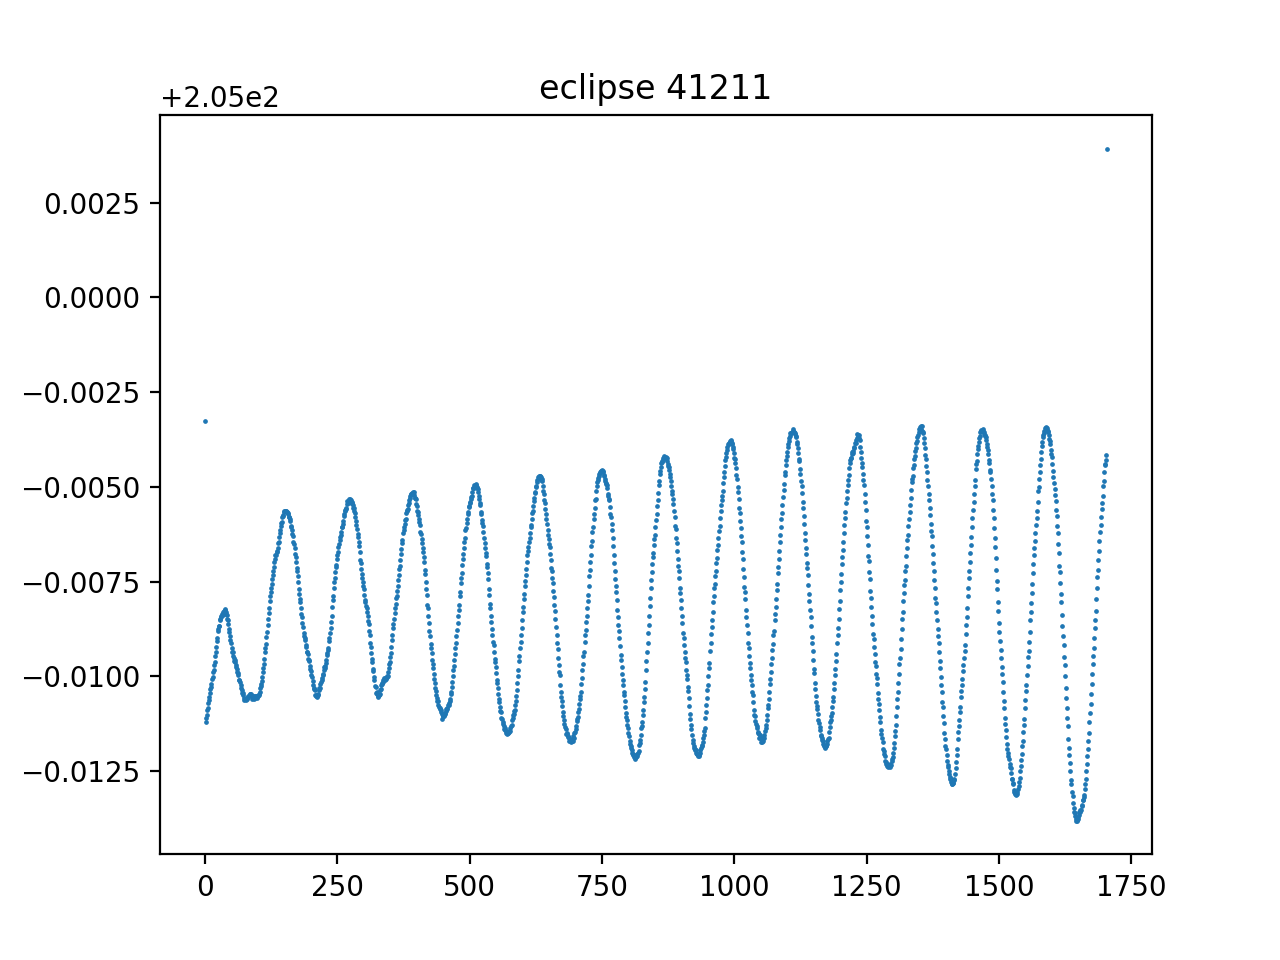

Text(0.5, 1.0, 'eclipse 41211')

In [115]:
%matplotlib notebook
random = aspect.sample()["eclipse"]
eclipse = random.values.item()

asprta_roll_781 = aspect[aspect["eclipse"]==eclipse]["roll"].reset_index()
plt.scatter(asprta_roll_781.index,asprta_roll_781["roll"],s=0.5)
plt.title(f"eclipse {eclipse}")

In [111]:
aspect[aspect["eclipse"]==9869]

,eclipse,time,ra,dec,roll,flags
7325566,9869,7.939713e+08,160.707959,58.508936,190.996912,49
7325567,9869,7.939713e+08,160.708330,58.508920,190.997359,49
7325568,9869,7.939713e+08,160.708786,58.508986,190.997885,49
7325569,9869,7.939714e+08,160.709135,58.508940,190.998247,49
7325570,9869,7.939714e+08,160.709476,58.509029,190.998648,49
...,...,...,...,...,...,...
7327202,9869,7.939730e+08,160.690453,58.523630,190.991365,0
7327203,9869,7.939730e+08,160.689614,58.523089,190.990682,0
7327204,9869,7.939730e+08,160.688860,58.522606,190.990050,0
7327205,9869,7.939730e+08,160.688226,58.521791,190.980203,17


In [ ]:
random = aspect.sample()["eclipse"]
eclipse = random.values.item()
print(random.values.item())
print(type(random.values.item()))

In [ ]:
%matplotlib notebook

asprta_roll_781 = aspect[aspect["eclipse"]==9871] #["roll"].reset_index()
plt.scatter(asprta_roll_781["time"],asprta_roll_781["roll"],s=0.5)
plt.title("9871")
plt.xlabel("time")

In [ ]:
%matplotlib notebook

asprta_roll_780 = aspect[aspect["eclipse"]==780]["roll"].reset_index()
plt.scatter(asprta_roll_780.index,asprta_roll_780["roll"],s=0.5)

In [ ]:
%matplotlib notebook

asprta_roll_2025 = aspect[aspect["eclipse"]==2025]["roll"].reset_index()
plt.scatter(asprta_roll_2025.index,asprta_roll_2025["roll"],s=0.5)

In [ ]:
%matplotlib notebook

asprta_roll_9871 = aspect[aspect["eclipse"]==9871]["roll"].reset_index()
plt.scatter(asprta_roll_9871.index,asprta_roll_9871["roll"],s=0.5)

In [ ]:
%matplotlib notebook

asprta_roll_581 = aspect[aspect["eclipse"]==581]["roll"].reset_index()
plt.scatter(asprta_roll_581.index,asprta_roll_581["roll"],s=0.5)

In [ ]:
from reference import check_eclipse

In [ ]:
check_eclipse(21348)

In [ ]:
%matplotlib notebook
plt.scatter(aspect[aspect["eclipse"]==9869]["ra"],aspect[aspect["eclipse"]==9869]["dec"],c=aspect[aspect["eclipse"]==9869].index,alpha=0.7,s=20)
#plt.scatter(bore[bore["eclipse"]==21442]['ra0'],bore[bore["eclipse"]==21442]['dec0'], c="purple")
#plt.scatter(my_data_6s[0],my_data_6s[1],c="black",alpha=0.5)
#plt.scatter(my_data_3s[0],my_data_3s[1],marker='+',c="orange",alpha=0.5)
#plt.scatter(my_data_1s_im[0],my_data_1s_im[1],marker='s',c="yellow")
#plt.scatter(201.057617, 27.476043, marker='*',s=200, c="black")
#plt.scatter(my_data_2s_dose[0],my_data_2s_dose[1],marker="*",c="black",alpha=0.5)
#plt.scatter(my_data_1s_fill[0],my_data_1s_fill[1],marker='o',c=my_data_1s_fill.index.astype(int),alpha=0.6)
#plt.scatter(d9869[0],d9869[1],marker='o',c="red")
plt.scatter(d9869_dose_2 ['ra_tangent'],d9869_dose_2 ['dec_tangent'],marker='+',c="red",alpha=0.8)
plt.scatter(d9869_dose [0],d9869_dose [1],marker='o',c="orange",alpha=0.5)
plt.colorbar()


In [ ]:
plt.scatter(aspect[aspect["eclipse"]==21442]["ra"],aspect[aspect["eclipse"]==21442]["dec"],c="blue",alpha=0.7,s=20)
plt.scatter(my_data_1s_sip[0],my_data_1s_sip[1],marker="*",c="green",alpha=0.5)

In [ ]:
from astropy import wcs


In [ ]:
hdulist = fits.open("/home/bekah/glcat_tests/astrometry_temp/frame74.wcs")

In [ ]:
 w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
print(w.wcs.name)

In [ ]:
    # Print out all of the settings that were parsed from the header
w.wcs.print_contents()

In [ ]:
e9869pic = fits.open("/home/bekah/gphoton_working/test_data/e09869/e09869-nd-tfull-b00-image-r.fits")

In [ ]:
e9871pic = fits.open("/home/bekah/gphoton_working/test_data/e09871/e09871-nd-tfull-b00-image-r.fits")

In [ ]:
e9869pic_b = fits.open("/home/bekah/gphoton_working/test_data/e09869/e09869-nd-tfull-b00-image-g_back.fits")

In [ ]:
e9871pic = fits.open("/home/bekah/gphoton_working/test_data/e09871/e09871-nd-tfull-b00-image-r.fits")

In [ ]:
%matplotlib notebook
plt.imshow(centile_clip(e9871pic[1].data,(0,99)),cmap='Greys_r',origin='lower')

In [ ]:
#hdulist = fits.open("/home/bekah/gphoton_working/test_data/e09869/e09869-nd-1s-0-f0032-rice.fits")
%matplotlib notebook
plt.imshow(centile_clip(e9869pic[1].data,(0,99.3)),cmap="Greys_r",origin='lower' )

In [ ]:
df9871 = pd.read_csv('/home/bekah/glcat_tests/aspect_solns/e09871_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho')

In [ ]:
df9871['orientation']

In [ ]:
df9869 = pd.read_csv('/home/bekah/glcat_tests/aspect_solns/e09869_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho')

In [ ]:
df9869['orientation']

In [ ]:
df9869.keys()

In [ ]:
%matplotlib notebook
plt.scatter(aspect[aspect["eclipse"]==9869]["ra"],aspect[aspect["eclipse"]==9869]["dec"],c="blue",alpha=0.2,s=20)
plt.scatter(df9869["ra_tangent"],df9869["dec_tangent"],marker="*",c="green",alpha=0.9)
plt.scatter(df9869["ra_center"],df9869["dec_center"],marker="+",c="red",alpha=0.9)

In [ ]:
plt.scatter(df9869.index,df9869["orientation"],marker="*",c="green",alpha=0.9,s=3)

In [ ]:
plt.scatter(aspect[aspect["eclipse"]==9869]["time"],aspect[aspect["eclipse"]==9869]["roll"],c="blue",alpha=0.2,s=6)

In [ ]:
# function to fill in gaps 
df9869.dtypes.to_dict()

In [ ]:
re = df9869.reindex(range(1639),method=None)
re

In [ ]:
failed_frames = re.index[re.isnull().all(1)]


In [ ]:
failed_frames